# Figure 1

In [1]:
# Import packages.
import allel
import matplotlib
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import zarr
# Print version numbers.
print('allel', allel.__version__)
print('matplotlib', matplotlib.__version__)
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('zarr', zarr.__version__)

allel 1.3.5
matplotlib 3.5.2
numpy 1.22.3
pandas 1.4.2
zarr 2.11.3


In [2]:
# Intialize the matplolib styling.
plt.rcParams.update({
    'figure.constrained_layout.use': True,
    'figure.facecolor': 'white',
    'font.family': 'serif',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
})
# Intialize the numpy warning preferences.
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# Import the TGP meta data.
tgp_df = pd.read_csv(
    './data/tgp_mod.txt', sep='\t',
    names=['IND', 'POP', 'SUPERPOP'],
)
# Intialize a super population list.
tgp_superpop_list = ['AFR', 'SAS', 'EAS', 'EUR', 'AMR']
# Intialize an ordered population list.
tgp_pop_list = [
    'LWK', 'GWD', 'MSL', 'ESN', 'YRI', # AFR.
    'BEB', 'STU', 'ITU', 'PJL', 'GIH', # SAS.
    'CHB', 'KHV', 'CHS', 'JPT', 'CDX', # EAS.    
    'TSI', 'CEU', 'IBS', 'GBR', 'FIN', # EUR.
    'PEL', 'MXL', 'CLM', 'PUR', # AMR.
]
# Define an OOA population list.
ooa_pop_list = [
    'PEL', 'MXL', 'CLM', 'PUR',
    'CHB', 'KHV', 'CHS', 'JPT', 'CDX',
    'TSI', 'CEU', 'IBS', 'GBR', 'FIN',
    'BEB', 'STU', 'ITU', 'PJL', 'GIH',
]
# Intialize a list of archaics.
arc_list = ['DEN', 'ALT', 'CHA', 'VIN']
# Intialize a samples dictionary.
idx_dicc = {
    'DEN': np.array([2350]), 'ALT': np.array([2347]),
    'CHA': np.array([2348]), 'VIN': np.array([2349]),
    
}
# For every super population...
for superpop in tgp_superpop_list:
    # Fill the sample dictionary.
    idx_dicc[superpop] = tgp_df[tgp_df['SUPERPOP'] == superpop].index.values
# For every population...
for pop in tgp_pop_list:
    # Fill the sample dictionary.
    idx_dicc[pop] = tgp_df[tgp_df['POP'] == pop].index.values
# Append the OOA superpopulations.
idx_dicc['OOA'] = tgp_df[tgp_df['SUPERPOP'] != 'AFR'].index.values
# Intialize a dictionary to store all sample indicies.
pbs_idx_dicc = {
    'MXL_NAT': np.loadtxt('../meta_data/mxl_nat_idx.csv', delimiter=',', dtype=int),
    'MXL_NOT': np.loadtxt('../meta_data/mxl_not_idx.csv', delimiter=',', dtype=int),
    'MXL': tgp_df[tgp_df['POP'] == 'MXL'].index.values,
    'CEU': tgp_df[tgp_df['POP'] == 'CEU'].index.values,
    'CHB': tgp_df[tgp_df['POP'] == 'CHB'].index.values,
}

In [4]:
# Define a function to load genotyope and positions arrays.
def load_gt_pos():
    # Intialize the file path.
    path = './data/tgp_mod_arc_anc_748kb.zarr'
    # Load the zarr array.
    zarr_array = zarr.open_group(path, mode='r')
    # Extract the genotype callset.
    callset = zarr_array['12/calldata/GT']
    # Convert the genotype callset to an array.
    gt = allel.GenotypeArray(callset)
    # Load the positions.
    pos = allel.SortedIndex(zarr_array['12/variants/POS'])
    return gt, pos

In [5]:
# Define a function to calculate alternative allele frequencies.
def calc_alt_freqs(gt):
    # If there are no altenative alleles...
    if (gt.count_alleles().shape[1] == 1):
        # Calculate alternative allele frequencies.
        alt_freqs = gt.count_alleles().to_frequencies()[:, 0] - 1
    # Else...
    else:
        # Calculate alternative allele frequencies.
        alt_freqs = gt.count_alleles().to_frequencies()[:, 1]
    return alt_freqs

In [6]:
# Define a function to exctract derived archaic specific snps.
def extract_arc_der_sites(gt, pos, pop_dicc):
    # Calculate alternative allele frequencies.
    afr_alt_freq = calc_alt_freqs(gt.take(pop_dicc['AFR'], axis=1))
    ooa_alt_freq = calc_alt_freqs(gt.take(pop_dicc['OOA'], axis=1))
    alt_alt_freq = calc_alt_freqs(gt.take(pop_dicc['ALT'], axis=1))
    cha_alt_freq = calc_alt_freqs(gt.take(pop_dicc['CHA'], axis=1))
    vin_alt_freq = calc_alt_freqs(gt.take(pop_dicc['VIN'], axis=1))
    den_alt_freq = calc_alt_freqs(gt.take(pop_dicc['DEN'], axis=1))
    anc_freq = calc_alt_freqs(gt.take([-1], axis=1))
    # Polarize the samples.
    afr_der_freq = np.where(anc_freq == 1, np.abs(afr_alt_freq - 1), afr_alt_freq)
    ooa_der_freq = np.where(anc_freq == 1, np.abs(ooa_alt_freq - 1), ooa_alt_freq)
    alt_der_freq = np.where(anc_freq == 1, np.abs(alt_alt_freq - 1), alt_alt_freq)
    cha_der_freq = np.where(anc_freq == 1, np.abs(cha_alt_freq - 1), cha_alt_freq)
    vin_der_freq = np.where(anc_freq == 1, np.abs(vin_alt_freq - 1), vin_alt_freq)
    den_der_freq = np.where(anc_freq == 1, np.abs(den_alt_freq - 1), den_alt_freq)
    # Intialize conditions.
    c_hum = (afr_der_freq < 0.01) & (ooa_der_freq > 0)
    c_den = (den_der_freq == 1)
    c_not_den = (den_der_freq != 1)
    c_alt = (alt_der_freq == 1)
    c_not_alt = (alt_der_freq != 1)
    c_cha = (cha_der_freq == 1)
    c_not_cha = (cha_der_freq != 1)
    c_vin = (vin_der_freq == 1)
    c_not_vin = (vin_der_freq != 1)
    c_nea = c_alt | c_cha | c_vin
    c_not_nea = c_not_alt & c_not_cha & c_not_vin
    # Determine the archaic specific sites.
    den_only_idx = np.where(c_hum & c_not_nea & c_den)[0]
    nea_only_idx = np.where(c_hum & c_not_den & c_nea)[0]
    # Construct the masks.
    den_mask = np.in1d(np.arange(pos.size), den_only_idx)
    nea_mask = np.in1d(np.arange(pos.size), nea_only_idx)
    # Compile a dictionary with the results.
    arc_sites_dicc = {
        'DEN': {'IDX': den_only_idx, 'MASK': den_mask},
        'NEA': {'IDX': nea_only_idx, 'MASK': nea_mask},
    }
    return arc_sites_dicc

In [7]:
# Define a function to exctract ancestral archaic specific snps.
def extract_arc_anc_sites(gt, pos, pop_dicc):
    # Calculate alternative allele frequencies.
    afr_alt_freq = calc_alt_freqs(gt.take(pop_dicc['AFR'], axis=1))
    ooa_alt_freq = calc_alt_freqs(gt.take(pop_dicc['OOA'], axis=1))
    alt_alt_freq = calc_alt_freqs(gt.take(pop_dicc['ALT'], axis=1))
    cha_alt_freq = calc_alt_freqs(gt.take(pop_dicc['CHA'], axis=1))
    vin_alt_freq = calc_alt_freqs(gt.take(pop_dicc['VIN'], axis=1))
    den_alt_freq = calc_alt_freqs(gt.take(pop_dicc['DEN'], axis=1))
    anc_freq = calc_alt_freqs(gt.take([-1], axis=1))
    # Polarize the samples.
    afr_der_freq = np.where(anc_freq == 1, np.abs(afr_alt_freq - 1), afr_alt_freq)
    ooa_der_freq = np.where(anc_freq == 1, np.abs(ooa_alt_freq - 1), ooa_alt_freq)
    alt_der_freq = np.where(anc_freq == 1, np.abs(alt_alt_freq - 1), alt_alt_freq)
    cha_der_freq = np.where(anc_freq == 1, np.abs(cha_alt_freq - 1), cha_alt_freq)
    vin_der_freq = np.where(anc_freq == 1, np.abs(vin_alt_freq - 1), vin_alt_freq)
    den_der_freq = np.where(anc_freq == 1, np.abs(den_alt_freq - 1), den_alt_freq)
    # Intialize conditions.
    c_hum = ((1 - afr_der_freq) < 0.01) & ((1 - ooa_der_freq) > 0)
    c_den = (den_der_freq == 0)
    c_not_den = (den_der_freq != 0)
    c_alt = (alt_der_freq == 0)
    c_not_alt = (alt_der_freq != 0)
    c_cha = (cha_der_freq == 0)
    c_not_cha = (cha_der_freq != 0)
    c_vin = (vin_der_freq == 0)
    c_not_vin = (vin_der_freq != 0)
    c_nea = c_alt | c_cha | c_vin
    c_not_nea = c_not_alt & c_not_cha & c_not_vin
    # Determine the archaic specific sites.
    den_only_idx = np.where(c_hum & c_not_nea & c_den)[0]
    nea_only_idx = np.where(c_hum & c_not_den & c_nea)[0]
    # Construct the masks.
    den_mask = np.in1d(np.arange(pos.size), den_only_idx)
    nea_mask = np.in1d(np.arange(pos.size), nea_only_idx)
    # Compile a dictionary with the results.
    arc_sites_dicc = {
        'DEN': {'IDX': den_only_idx, 'MASK': den_mask},
        'NEA': {'IDX': nea_only_idx, 'MASK': nea_mask},
    }
    return arc_sites_dicc

In [8]:
# Define a function to calculate PBS.
def calc_pbs(gt, pop_a, pop_b, pop_c):
    # Determine allele counts.
    a_ac = gt.take(pop_a, axis=1).count_alleles()
    b_ac = gt.take(pop_b, axis=1).count_alleles()
    c_ac = gt.take(pop_c, axis=1).count_alleles()
    # Calculate the numerator and denominator for Hudson's Fst estimator.
    a_b_num, a_b_den = allel.hudson_fst(a_ac, b_ac)
    a_c_num, a_c_den = allel.hudson_fst(a_ac, c_ac)
    c_b_num, c_b_den = allel.hudson_fst(c_ac, b_ac)
    # Calculate Fst.
    a_b_raw_fst = a_b_num / a_b_den
    a_c_raw_fst = a_c_num / a_c_den
    c_b_raw_fst = c_b_num / c_b_den
    # Correct for Fst values of 1 that will lead to inf.
    a_b_fst_raw = np.where(a_b_raw_fst == 1, 0.99999, a_b_raw_fst)
    a_c_fst_raw = np.where(a_c_raw_fst == 1, 0.99999, a_c_raw_fst)
    c_b_fst_raw = np.where(c_b_raw_fst == 1, 0.99999, c_b_raw_fst)
    # Correct for negative Fst values.
    a_b_fst = np.where(a_b_fst_raw < 0, 0, a_b_fst_raw)
    a_c_fst = np.where(a_c_fst_raw < 0, 0, a_c_fst_raw)
    c_b_fst = np.where(c_b_fst_raw < 0, 0, c_b_fst_raw)
    # Calculate PBS.
    pbs = (
        ((np.log(1.0 - a_b_fst) * -1.0) +\
         (np.log(1.0 - a_c_fst) * -1.0) -\
         (np.log(1.0 - c_b_fst) * -1.0)) / float(2)
    )
    return pbs, np.nanmean(pbs)

In [9]:
# Define a function to load the per-SNP PBS values.
def load_pbs_chromosomes(anc):
    # Intialize an array to store the results.
    all_pbs = np.array([])
    # For all chromosomes...
    for chrom in range(1, 23):
        # Load the pbs data.
        chrom_pbs = np.loadtxt(
            f'./data/mxl_{anc}_chb_ceu_pbs_chr{chrom}.csv.gz', delimiter=',',
        )
        # Append the results.
        all_pbs = np.append(all_pbs, chrom_pbs)
    return all_pbs

In [10]:
# Import the genotype matrix.
tgp_748kb_gt, tgp_748kb_pos = load_gt_pos()

In [11]:
# Extract the archaic specific snps.
arc_der_dicc = extract_arc_der_sites(tgp_748kb_gt, tgp_748kb_pos, idx_dicc)
arc_anc_dicc = extract_arc_anc_sites(tgp_748kb_gt, tgp_748kb_pos, idx_dicc)
# Intialize a dictionary to store joint masks.
arc_dicc = {'DEN': {}, 'NEA': {}}
# For each archaic...
for key in arc_dicc.keys():
    # Fille the dictionary.
    arc_dicc[key]['MASK'] = arc_der_dicc[key]['MASK'] | arc_anc_dicc[key]['MASK']

In [12]:
# Intialize a results dictionary.
pbs_748kb_dicc = {}
# For each group.
for group in ['MXL', 'MXL_NAT', 'MXL_NOT']:
    # Compute per-SNP PBS.
    pbs, _  = calc_pbs(
        gt=tgp_748kb_gt, pop_a=pbs_idx_dicc[group],
        pop_b=pbs_idx_dicc['CHB'], pop_c=pbs_idx_dicc['CEU'],
    )
    # Update the dictionary.
    pbs_748kb_dicc[group] = pbs

In [13]:
# Intialize a results dictionary.
pbs_genome_dicc = {}
# Load the PBS values for every SNP in the genome.
pbs_genome_dicc['MXL'] = load_pbs_chromosomes('pop')
pbs_genome_dicc['MXL_NAT'] = load_pbs_chromosomes('nat')
pbs_genome_dicc['MXL_NOT'] = load_pbs_chromosomes('not')

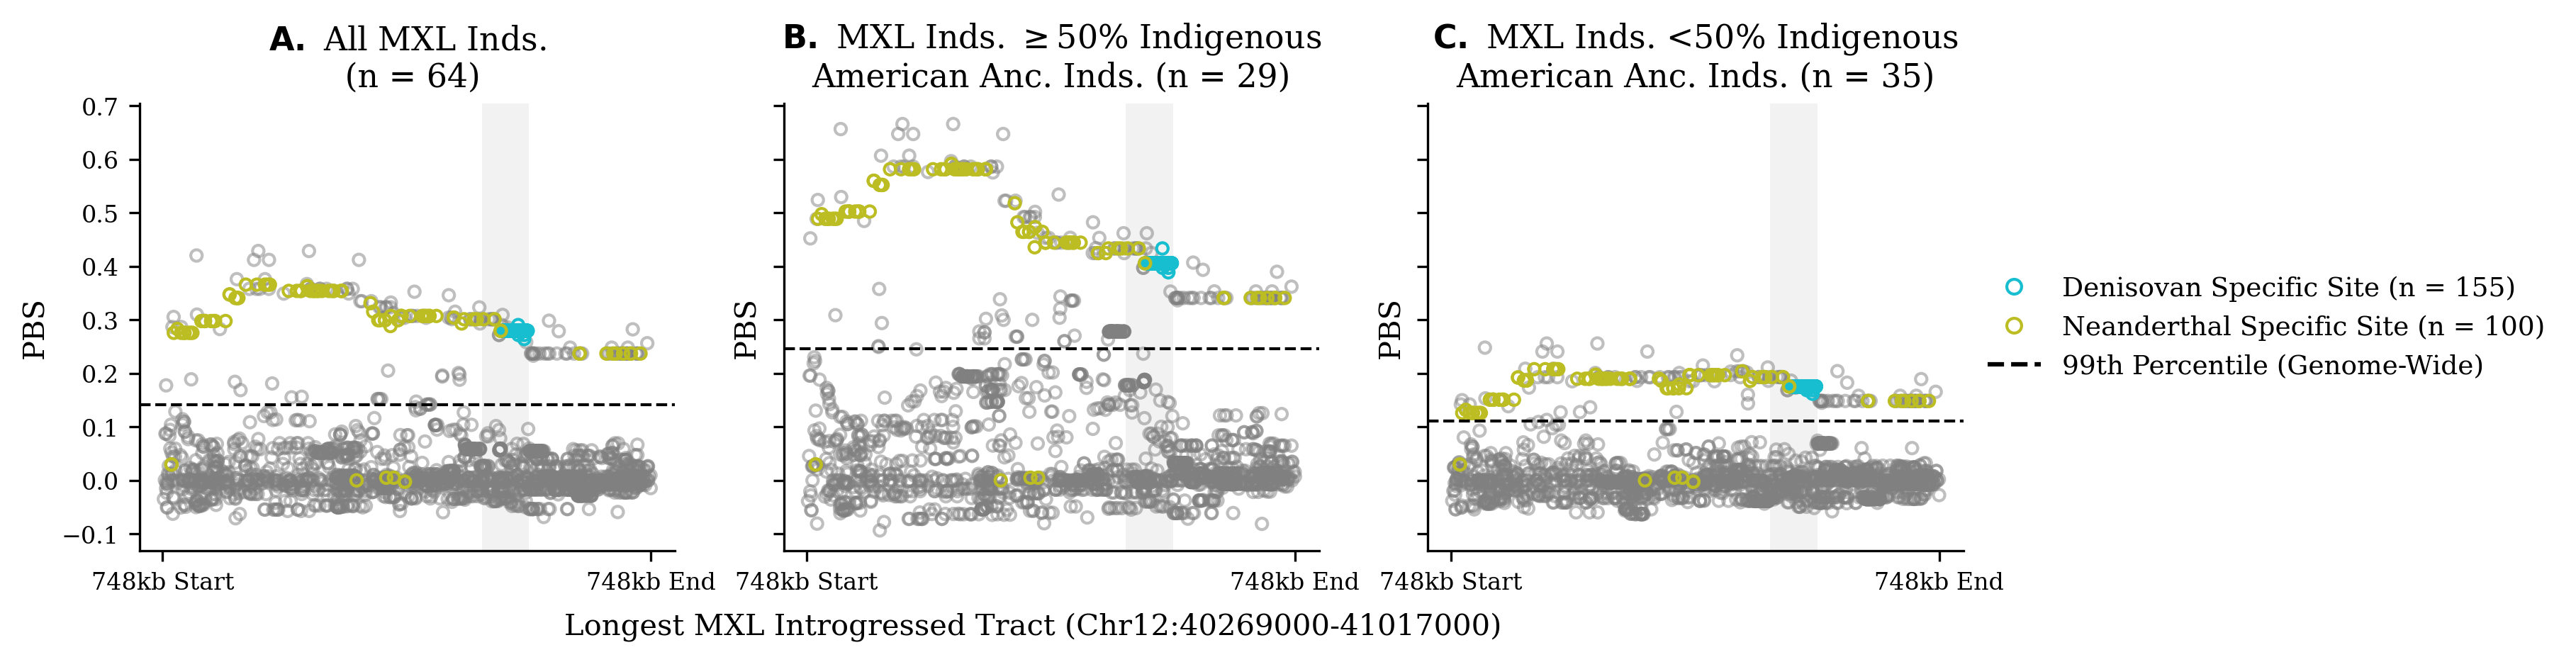

In [14]:
# Intialize figures and axes.
fig, axes = plt.subplots(
     1, 3, figsize=(12, 3),
    sharex=True, sharey=True, dpi=300,
)
# Intalize the subplot titles.
raw_titles = [
    r'$\bf{A.}$ All MXL Inds.'+'\n',
    r'$\bf{B.}$ MXL Inds. $\geq$50% Indigenous'+'\n'+'American Anc. Inds.',
    r'$\bf{C.}$ MXL Inds. <50% Indigenous'+'\n'+'American Anc. Inds.',
]
title_list = []
# For every pbs comparison.
for i, key in enumerate(['MXL', 'MXL_NAT', 'MXL_NOT']):
    # Create the formatted title.
    title_list.append(raw_titles[i]+f' (n = {pbs_idx_dicc[key].size})')
# Intialize mask and color lists.
mask_list = [arc_dicc[key]['MASK'] for key in arc_dicc.keys()]
c_list = ['tab:cyan', 'tab:olive']
# For every PBS partition.
for i, anc in enumerate(pbs_748kb_dicc.keys()):
    # Plot the 72kb haplotype region.
    axes[i].axvspan(
        40758000, 40830000,
        alpha=0.1, facecolor='gray',
    )
    # Plot the per-site PBS results.
    axes[i].scatter(
        tgp_748kb_pos[~(mask_list[0] | mask_list[1])],
        pbs_748kb_dicc[anc][~(mask_list[0] | mask_list[1])],
        color='gray', marker='o', facecolor='none', alpha=0.5, s=15,
    )
    # For all archaic specific snps...
    for j in range(2):
        # Plot the archaic specific PBS results.
        axes[i].scatter(
            tgp_748kb_pos[mask_list[j]], pbs_748kb_dicc[anc][mask_list[j]],
            color=c_list[j], marker='o', facecolor='none', s=15,
        )
    # Plot the genome-wide outlier threshold.
    axes[i].axhline(
        np.nanpercentile(pbs_genome_dicc[anc], 99),
        0, 1, color='black', linestyle='dashed', lw=1,
    )
    # Title the subplot.
    axes[i].set_title(title_list[i], size=11)
    # Adjust the x-axis ticks and labels.
    axes[i].set_xticks([tgp_748kb_pos[0], tgp_748kb_pos[-1]])
    axes[i].set_xticklabels(['748kb Start', '748kb End'], size=8)
    # Adjust the y-axis tick size.
    axes[i].tick_params(axis='y', labelsize=8)
    # Set the y-axis label
    axes[i].set_ylabel('PBS', size=10)
# Intialize the super axes label
fig.supxlabel(f'Longest MXL Introgressed Tract (Chr12:40269000-41017000)', size=10, x=0.4)
# Configure the legend.
legend_elements = [
    Line2D([0], [0], marker='o', markersize=5, color='white', markeredgecolor='tab:cyan', label=f'Denisovan Specific Site (n = {mask_list[0].sum()})'),
    Line2D([0], [0], marker='o', markersize=5, color='white', markeredgecolor='tab:olive', label=f'Neanderthal Specific Site (n = {mask_list[1].sum()})'),
    Line2D([0], [0], color='black', linestyle='dashed', label='99th Percentile (Genome-Wide)'),
]
# Add a figure legend.
axes[i].legend(
    handles=legend_elements, loc='center left',
    bbox_to_anchor=(1.0, 0.5), frameon=False,
    fontsize=9,
)
# Export the plot.
plt.savefig(
    './figures/figure_1.png', format='png',
    facecolor='white', bbox_inches='tight', dpi=500,
)
# Show the plot!
plt.show()